# Example for the teleconnections

In [1]:
import yaml
import xarray as xr
import matplotlib.pyplot as plt

diagname = 'teleconnections'
machine = 'wilma'

with open(f'../../config/config_{machine}.yml', 'r', encoding='utf-8') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

with open(f'{diagname}.yml', 'r', encoding='utf-8') as file:
    namelist = yaml.load(file, Loader=yaml.FullLoader)

infile = config['input'][diagname]

field = xr.open_mfdataset(infile)['msl']

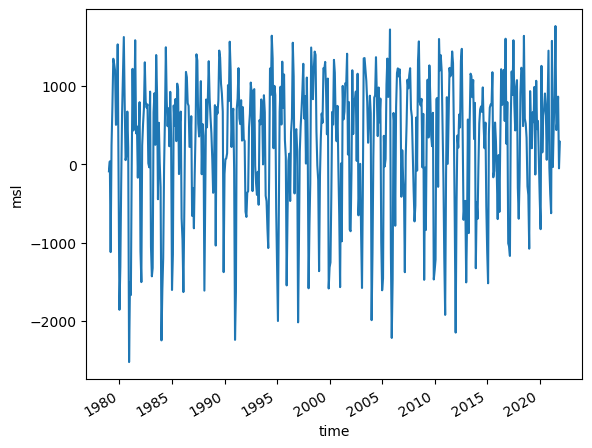

In [7]:
prs1 = field.sel(lon=namelist['lon1'],lat=namelist['lat1'])
prs2 = field.sel(lon=namelist['lon2'],lat=namelist['lat2'])

indx = prs1-prs2
indx.plot()